In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 21
lead_time = 90
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
pcmciplus_features = ['LW_down', 'snowfall', 'sst', 'sosaline', 'surface_pressure', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

Day  wind_10m  specific_humidity     LW_down   SW_down  rainfall  \
7305  1/1/1999  4.987515           0.891843  183.786092  1.120906  0.700735   
7306  1/2/1999  5.075952           0.905535  183.851814  1.193514  0.712730   
7307  1/3/1999  4.931520           0.911672  184.426913  1.263909  0.677339   
7308  1/4/1999  4.761644           0.911301  187.528326  1.269229  0.824016   
7309  1/5/1999  4.739850           0.901353  187.326709  1.552208  0.926681   

      snowfall   sosaline         sst         t2m  surface_pressure  \
7305  0.501109  33.316996  273.467869  250.884060        985.112721   
7306  0.482221  33.316996  273.453826  250.359328        984.092282   
7307  0.480718  33.316996  273.454385  250.327500        982.300080   
7308  0.697950  33.316996  273.459797  249.905730        983.250565   
7309  0.835868  33.316996  273.463975  250.254873        984.247389   

      sea_ice_extent  
7305        13823248  
7306        13885522  
7307        13884279  
7308        13912624  
7309        13890148

In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
# df = df[pcmciplus_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + lead_time])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14784     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,921
Trainable params: 121,921
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0240 - mae: 0.1063 - mse: 0.0240

81/81 [==============================] - 10s 17ms/step - loss: 0.0230 - mae: 0.1041 - mse: 0.0230 - val_loss: 0.0015 - val_mae: 0.0317 - val_mse: 0.0015
Epoch 2/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0065 - mae: 0.0644 - mse: 0.0065

81/81 [==============================] - 1s 9ms/step - loss: 0.0064 - mae: 0.0640 - mse: 0.0064 - val_loss: 0.0014 - val_mae: 0.0313 - val_mse: 0.0014
Epoch 3/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0051 - mae: 0.0574 - mse: 0.0051

81/81 [==============================] - 1s 8ms/step - loss: 0.0052 - mae: 0.0576 - mse: 0.0052 - val_loss: 0.0010 - val_mae: 0.0252 - val_mse: 0.0010
Epoch 4/100
79/81 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0546 - mse: 0.0047

81/81 [==============================] - 1s 8ms/step - loss: 0.0047 - mae: 0.0547 - mse: 0.0047 - val_loss: 7.0441e-04 - val_mae: 0.0207 - val_mse: 7.0441e-04
Epoch 5/100
81/81 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0500 - mse: 0.0039

81/81 [==============================] - 1s 8ms/step - loss: 0.0039 - mae: 0.0500 - mse: 0.0039 - val_loss: 8.2009e-04 - val_mae: 0.0232 - val_mse: 8.2009e-04
Epoch 6/100
80/81 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0488 - mse: 0.0038

81/81 [==============================] - 1s 8ms/step - loss: 0.0038 - mae: 0.0488 - mse: 0.0038 - val_loss: 6.0157e-04 - val_mae: 0.0200 - val_mse: 6.0157e-04
Epoch 7/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0035 - mae: 0.0465 - mse: 0.0035

81/81 [==============================] - 1s 8ms/step - loss: 0.0035 - mae: 0.0466 - mse: 0.0035 - val_loss: 5.2593e-04 - val_mae: 0.0188 - val_mse: 5.2593e-04
Epoch 8/100
81/81 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0455 - mse: 0.0033

81/81 [==============================] - 1s 9ms/step - loss: 0.0033 - mae: 0.0455 - mse: 0.0033 - val_loss: 0.0011 - val_mae: 0.0271 - val_mse: 0.0011
Epoch 9/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0032 - mae: 0.0448 - mse: 0.0032

81/81 [==============================] - 1s 8ms/step - loss: 0.0032 - mae: 0.0449 - mse: 0.0032 - val_loss: 5.4140e-04 - val_mae: 0.0186 - val_mse: 5.4140e-04
Epoch 10/100
80/81 [============================>.] - ETA: 0s - loss: 0.0031 - mae: 0.0439 - mse: 0.0031

81/81 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0439 - mse: 0.0031 - val_loss: 0.0010 - val_mae: 0.0250 - val_mse: 0.0010
Epoch 11/100
80/81 [============================>.] - ETA: 0s - loss: 0.0029 - mae: 0.0423 - mse: 0.0029

81/81 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0423 - mse: 0.0029 - val_loss: 6.9207e-04 - val_mae: 0.0211 - val_mse: 6.9207e-04
Epoch 12/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0417 - mse: 0.0028

81/81 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0418 - mse: 0.0028 - val_loss: 5.1979e-04 - val_mae: 0.0188 - val_mse: 5.1979e-04
Epoch 13/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0423 - mse: 0.0029

81/81 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0423 - mse: 0.0029 - val_loss: 0.0016 - val_mae: 0.0327 - val_mse: 0.0016
Epoch 14/100
81/81 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0411 - mse: 0.0027

81/81 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0411 - mse: 0.0027 - val_loss: 0.0015 - val_mae: 0.0323 - val_mse: 0.0015
Epoch 15/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0418 - mse: 0.0029

81/81 [==============================] - 1s 10ms/step - loss: 0.0029 - mae: 0.0417 - mse: 0.0029 - val_loss: 0.0015 - val_mae: 0.0324 - val_mse: 0.0015
Epoch 16/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0393 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0392 - mse: 0.0025 - val_loss: 7.7790e-04 - val_mae: 0.0230 - val_mse: 7.7790e-04
Epoch 17/100
80/81 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0393 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0393 - mse: 0.0025 - val_loss: 5.7792e-04 - val_mae: 0.0196 - val_mse: 5.7792e-04
Epoch 18/100
80/81 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0392 - mse: 0.0025

81/81 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0392 - mse: 0.0025 - val_loss: 6.5167e-04 - val_mae: 0.0195 - val_mse: 6.5167e-04
Epoch 19/100
81/81 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0374 - mse: 0.0023

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0374 - mse: 0.0023 - val_loss: 9.1876e-04 - val_mae: 0.0264 - val_mse: 9.1876e-04
Epoch 20/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0024 - mae: 0.0378 - mse: 0.0024

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0375 - mse: 0.0023 - val_loss: 0.0017 - val_mae: 0.0310 - val_mse: 0.0017
Epoch 21/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0370 - mse: 0.0022

81/81 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0371 - mse: 0.0023 - val_loss: 8.5993e-04 - val_mae: 0.0236 - val_mse: 8.5993e-04
Epoch 22/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0355 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0355 - mse: 0.0021 - val_loss: 0.0015 - val_mae: 0.0300 - val_mse: 0.0015
Epoch 23/100
79/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0359 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0358 - mse: 0.0021 - val_loss: 4.3207e-04 - val_mae: 0.0167 - val_mse: 4.3207e-04
Epoch 24/100
80/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0360 - mse: 0.0021

81/81 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0360 - mse: 0.0021 - val_loss: 6.1336e-04 - val_mae: 0.0199 - val_mse: 6.1336e-04
Epoch 25/100
79/81 [============================>.] - ETA: 0s - loss: 0.0021 - mae: 0.0357 - mse: 0.0021

81/81 [==============================] - 1s 9ms/step - loss: 0.0021 - mae: 0.0356 - mse: 0.0021 - val_loss: 6.2224e-04 - val_mae: 0.0205 - val_mse: 6.2224e-04
Epoch 26/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0348 - mse: 0.0020

81/81 [==============================] - 1s 13ms/step - loss: 0.0020 - mae: 0.0348 - mse: 0.0020 - val_loss: 0.0017 - val_mae: 0.0358 - val_mse: 0.0017
Epoch 27/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0357 - mse: 0.0022

81/81 [==============================] - 1s 13ms/step - loss: 0.0021 - mae: 0.0357 - mse: 0.0021 - val_loss: 5.5066e-04 - val_mae: 0.0190 - val_mse: 5.5066e-04
Epoch 28/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 7.5854e-04 - val_mae: 0.0226 - val_mse: 7.5854e-04
Epoch 29/100
81/81 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021

81/81 [==============================] - 1s 13ms/step - loss: 0.0021 - mae: 0.0352 - mse: 0.0021 - val_loss: 0.0014 - val_mae: 0.0299 - val_mse: 0.0014
Epoch 30/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 15ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 8.3510e-04 - val_mae: 0.0230 - val_mse: 8.3510e-04
Epoch 31/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0337 - mse: 0.0019

81/81 [==============================] - 1s 12ms/step - loss: 0.0019 - mae: 0.0337 - mse: 0.0019 - val_loss: 8.9901e-04 - val_mae: 0.0236 - val_mse: 8.9901e-04
Epoch 32/100
80/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0321 - mse: 0.0017

81/81 [==============================] - 1s 12ms/step - loss: 0.0018 - mae: 0.0322 - mse: 0.0018 - val_loss: 0.0013 - val_mae: 0.0294 - val_mse: 0.0013
Epoch 33/100
81/81 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0342 - mse: 0.0020

81/81 [==============================] - 1s 14ms/step - loss: 0.0020 - mae: 0.0342 - mse: 0.0020 - val_loss: 0.0013 - val_mae: 0.0287 - val_mse: 0.0013
Epoch 34/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018

81/81 [==============================] - 1s 14ms/step - loss: 0.0018 - mae: 0.0326 - mse: 0.0018 - val_loss: 9.4008e-04 - val_mae: 0.0238 - val_mse: 9.4008e-04
Epoch 35/100
80/81 [============================>.] - ETA: 0s - loss: 0.0019 - mae: 0.0336 - mse: 0.0019

81/81 [==============================] - 1s 13ms/step - loss: 0.0019 - mae: 0.0336 - mse: 0.0019 - val_loss: 0.0019 - val_mae: 0.0351 - val_mse: 0.0019
Epoch 36/100
81/81 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0343 - mse: 0.0020

81/81 [==============================] - 1s 13ms/step - loss: 0.0020 - mae: 0.0343 - mse: 0.0020 - val_loss: 7.6473e-04 - val_mae: 0.0234 - val_mse: 7.6473e-04
Epoch 37/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 15ms/step - loss: 0.0017 - mae: 0.0318 - mse: 0.0017 - val_loss: 0.0020 - val_mae: 0.0360 - val_mse: 0.0020
Epoch 38/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0319 - mse: 0.0017

81/81 [==============================] - 1s 13ms/step - loss: 0.0017 - mae: 0.0319 - mse: 0.0017 - val_loss: 0.0011 - val_mae: 0.0265 - val_mse: 0.0011
Epoch 39/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 14ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - val_loss: 8.6286e-04 - val_mae: 0.0238 - val_mse: 8.6286e-04
Epoch 40/100
79/81 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0314 - mse: 0.0017

81/81 [==============================] - 1s 13ms/step - loss: 0.0017 - mae: 0.0314 - mse: 0.0017 - val_loss: 0.0011 - val_mae: 0.0268 - val_mse: 0.0011
Epoch 41/100
80/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0312 - mse: 0.0016

81/81 [==============================] - 1s 10ms/step - loss: 0.0016 - mae: 0.0312 - mse: 0.0016 - val_loss: 0.0012 - val_mae: 0.0281 - val_mse: 0.0012
Epoch 42/100
80/81 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0310 - mse: 0.0016

81/81 [==============================] - 1s 12ms/step - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - val_loss: 8.8393e-04 - val_mae: 0.0233 - val_mse: 8.8393e-04
Epoch 43/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016

81/81 [==============================] - 1s 11ms/step - loss: 0.0016 - mae: 0.0306 - mse: 0.0016 - val_loss: 8.2697e-04 - val_mae: 0.0237 - val_mse: 8.2697e-04
Epoch 44/100
81/81 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0316 - mse: 0.0017

81/81 [==============================] - 1s 10ms/step - loss: 0.0017 - mae: 0.0316 - mse: 0.0017 - val_loss: 8.7500e-04 - val_mae: 0.0233 - val_mse: 8.7500e-04
Epoch 45/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0317 - mse: 0.0017

81/81 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0317 - mse: 0.0017 - val_loss: 0.0013 - val_mae: 0.0293 - val_mse: 0.0013
Epoch 46/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

81/81 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0012 - val_mae: 0.0257 - val_mse: 0.0012
Epoch 47/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0299 - mse: 0.0015

81/81 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 8.3527e-04 - val_mae: 0.0228 - val_mse: 8.3527e-04
Epoch 48/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0302 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0302 - mse: 0.0015 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 49/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0298 - mse: 0.0015 - val_loss: 0.0010 - val_mae: 0.0250 - val_mse: 0.0010
Epoch 50/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - val_loss: 8.7214e-04 - val_mae: 0.0231 - val_mse: 8.7214e-04
Epoch 51/100
81/81 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0287 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0287 - mse: 0.0014 - val_loss: 0.0017 - val_mae: 0.0352 - val_mse: 0.0017
Epoch 52/100
80/81 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - val_loss: 0.0020 - val_mae: 0.0353 - val_mse: 0.0020
Epoch 53/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0296 - mse: 0.0015

81/81 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0298 - mse: 0.0015 - val_loss: 0.0017 - val_mae: 0.0321 - val_mse: 0.0017
Epoch 54/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

81/81 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0291 - mse: 0.0014 - val_loss: 6.4025e-04 - val_mae: 0.0209 - val_mse: 6.4025e-04
Epoch 55/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

81/81 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0350 - val_mse: 0.0018
Epoch 56/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0294 - mse: 0.0015

81/81 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0294 - mse: 0.0015 - val_loss: 7.9537e-04 - val_mae: 0.0215 - val_mse: 7.9537e-04
Epoch 57/100
81/81 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0274 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0274 - mse: 0.0013 - val_loss: 0.0019 - val_mae: 0.0333 - val_mse: 0.0019
Epoch 58/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0277 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0277 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0302 - val_mse: 0.0013
Epoch 59/100
81/81 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0271 - mse: 0.0012 - val_loss: 0.0015 - val_mae: 0.0317 - val_mse: 0.0015
Epoch 60/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0274 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0275 - mse: 0.0013 - val_loss: 0.0014 - val_mae: 0.0291 - val_mse: 0.0014
Epoch 61/100
79/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0279 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 0.0010 - val_mae: 0.0255 - val_mse: 0.0010
Epoch 62/100
79/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0277 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0277 - mse: 0.0013 - val_loss: 0.0017 - val_mae: 0.0319 - val_mse: 0.0017
Epoch 63/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0270 - mse: 0.0012 - val_loss: 0.0014 - val_mae: 0.0306 - val_mse: 0.0014
Epoch 64/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0279 - mse: 0.0013

81/81 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0277 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0315 - val_mse: 0.0018
Epoch 65/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0273 - mse: 0.0012 - val_loss: 7.7058e-04 - val_mae: 0.0211 - val_mse: 7.7058e-04
Epoch 66/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0262 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0263 - mse: 0.0012 - val_loss: 0.0016 - val_mae: 0.0313 - val_mse: 0.0016
Epoch 67/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0258 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0271 - val_mse: 0.0012
Epoch 68/100
80/81 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0275 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0275 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0323 - val_mse: 0.0018
Epoch 69/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0019 - val_mae: 0.0323 - val_mse: 0.0019
Epoch 70/100
81/81 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0264 - mse: 0.0011

81/81 [==============================] - 1s 12ms/step - loss: 0.0011 - mae: 0.0264 - mse: 0.0011 - val_loss: 8.0411e-04 - val_mae: 0.0222 - val_mse: 8.0411e-04
Epoch 71/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0256 - mse: 0.0011

81/81 [==============================] - 1s 11ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0028 - val_mae: 0.0415 - val_mse: 0.0028
Epoch 72/100
79/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0253 - mse: 0.0011

81/81 [==============================] - 1s 16ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0015 - val_mae: 0.0286 - val_mse: 0.0015
Epoch 73/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 13ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0282 - val_mse: 0.0014
Epoch 74/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 11ms/step - loss: 0.0012 - mae: 0.0261 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0272 - val_mse: 0.0013
Epoch 75/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0262 - val_mse: 0.0011
Epoch 76/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0259 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0014 - val_mae: 0.0281 - val_mse: 0.0014
Epoch 77/100
74/81 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - val_loss: 0.0019 - val_mae: 0.0336 - val_mse: 0.0019
Epoch 78/100
76/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0254 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0016 - val_mae: 0.0304 - val_mse: 0.0016
Epoch 79/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0255 - mse: 0.0011

81/81 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0030 - val_mae: 0.0408 - val_mse: 0.0030
Epoch 80/100
77/81 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012

81/81 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 9.9563e-04 - val_mae: 0.0250 - val_mse: 9.9563e-04
Epoch 81/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0252 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0018 - val_mae: 0.0314 - val_mse: 0.0018
Epoch 82/100
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

81/81 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 7.5802e-04 - val_mae: 0.0228 - val_mse: 7.5802e-04
Epoch 83/100
80/81 [============================>.] - ETA: 0s - loss: 9.6817e-04 - mae: 0.0240 - mse: 9.6817e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.6813e-04 - mae: 0.0240 - mse: 9.6813e-04 - val_loss: 0.0020 - val_mae: 0.0358 - val_mse: 0.0020
Epoch 84/100
79/81 [============================>.] - ETA: 0s - loss: 9.1766e-04 - mae: 0.0236 - mse: 9.1766e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.1763e-04 - mae: 0.0236 - mse: 9.1763e-04 - val_loss: 0.0019 - val_mae: 0.0314 - val_mse: 0.0019
Epoch 85/100
77/81 [===========================>..] - ETA: 0s - loss: 9.8842e-04 - mae: 0.0244 - mse: 9.8842e-04

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0245 - mse: 0.0010 - val_loss: 0.0019 - val_mae: 0.0341 - val_mse: 0.0019
Epoch 86/100
75/81 [==========================>...] - ETA: 0s - loss: 9.8578e-04 - mae: 0.0244 - mse: 9.8578e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.8941e-04 - mae: 0.0245 - mse: 9.8941e-04 - val_loss: 0.0014 - val_mae: 0.0291 - val_mse: 0.0014
Epoch 87/100
78/81 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0024 - val_mae: 0.0409 - val_mse: 0.0024
Epoch 88/100
81/81 [==============================] - ETA: 0s - loss: 8.9413e-04 - mae: 0.0234 - mse: 8.9413e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.9413e-04 - mae: 0.0234 - mse: 8.9413e-04 - val_loss: 0.0016 - val_mae: 0.0299 - val_mse: 0.0016
Epoch 89/100
76/81 [===========================>..] - ETA: 0s - loss: 9.2173e-04 - mae: 0.0239 - mse: 9.2173e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.1649e-04 - mae: 0.0238 - mse: 9.1649e-04 - val_loss: 0.0020 - val_mae: 0.0358 - val_mse: 0.0020
Epoch 90/100
76/81 [===========================>..] - ETA: 0s - loss: 8.5960e-04 - mae: 0.0230 - mse: 8.5960e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.5270e-04 - mae: 0.0229 - mse: 8.5270e-04 - val_loss: 0.0021 - val_mae: 0.0375 - val_mse: 0.0021
Epoch 91/100
81/81 [==============================] - ETA: 0s - loss: 8.7950e-04 - mae: 0.0232 - mse: 8.7950e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7950e-04 - mae: 0.0232 - mse: 8.7950e-04 - val_loss: 0.0016 - val_mae: 0.0329 - val_mse: 0.0016
Epoch 92/100
77/81 [===========================>..] - ETA: 0s - loss: 9.3039e-04 - mae: 0.0237 - mse: 9.3039e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.4777e-04 - mae: 0.0239 - mse: 9.4777e-04 - val_loss: 0.0023 - val_mae: 0.0354 - val_mse: 0.0023
Epoch 93/100
76/81 [===========================>..] - ETA: 0s - loss: 9.9625e-04 - mae: 0.0248 - mse: 9.9625e-04

81/81 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - val_loss: 0.0010 - val_mae: 0.0246 - val_mse: 0.0010
Epoch 94/100
75/81 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0275 - mse: 0.0013

81/81 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0273 - mse: 0.0013 - val_loss: 0.0018 - val_mae: 0.0358 - val_mse: 0.0018
Epoch 95/100
79/81 [============================>.] - ETA: 0s - loss: 9.8959e-04 - mae: 0.0245 - mse: 9.8959e-04

81/81 [==============================] - 1s 8ms/step - loss: 9.9940e-04 - mae: 0.0247 - mse: 9.9940e-04 - val_loss: 0.0021 - val_mae: 0.0356 - val_mse: 0.0021
Epoch 96/100
78/81 [===========================>..] - ETA: 0s - loss: 8.8818e-04 - mae: 0.0234 - mse: 8.8818e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.9202e-04 - mae: 0.0234 - mse: 8.9202e-04 - val_loss: 0.0023 - val_mae: 0.0383 - val_mse: 0.0023
Epoch 97/100
77/81 [===========================>..] - ETA: 0s - loss: 8.0212e-04 - mae: 0.0222 - mse: 8.0212e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.0426e-04 - mae: 0.0222 - mse: 8.0426e-04 - val_loss: 0.0018 - val_mae: 0.0329 - val_mse: 0.0018
Epoch 98/100
77/81 [===========================>..] - ETA: 0s - loss: 9.5534e-04 - mae: 0.0239 - mse: 9.5534e-04

81/81 [==============================] - 1s 9ms/step - loss: 9.5055e-04 - mae: 0.0239 - mse: 9.5055e-04 - val_loss: 0.0017 - val_mae: 0.0346 - val_mse: 0.0017
Epoch 99/100
75/81 [==========================>...] - ETA: 0s - loss: 8.0262e-04 - mae: 0.0221 - mse: 8.0262e-04

81/81 [==============================] - 1s 8ms/step - loss: 7.9599e-04 - mae: 0.0220 - mse: 7.9599e-04 - val_loss: 0.0027 - val_mae: 0.0406 - val_mse: 0.0027
Epoch 100/100
79/81 [============================>.] - ETA: 0s - loss: 8.7869e-04 - mae: 0.0231 - mse: 8.7869e-04

81/81 [==============================] - 1s 8ms/step - loss: 8.7687e-04 - mae: 0.0231 - mse: 8.7687e-04 - val_loss: 0.0014 - val_mae: 0.0292 - val_mse: 0.0014


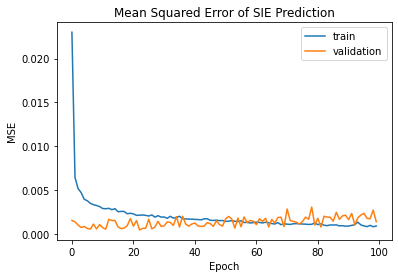

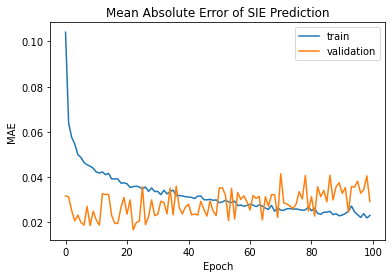

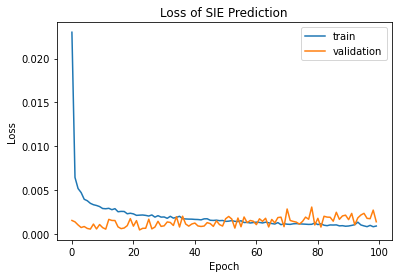

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 3ms/step


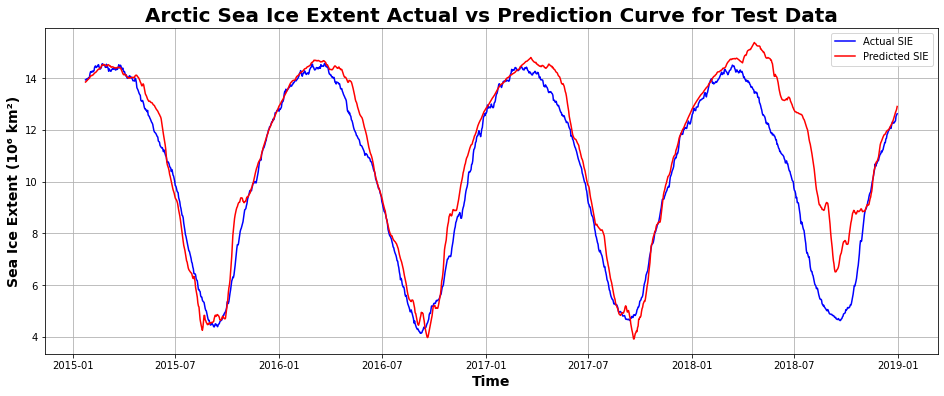

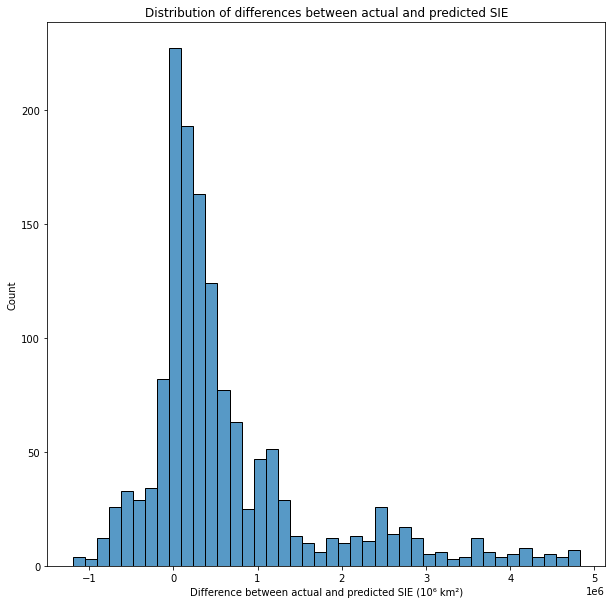

MSE :  1547113551925.349 (10⁶ km²)
MSPE : 3.312542581631263 %
RMSE :  1243830.1941685404 (10⁶ km²)
RMSPE : 18.20039170356304 %
MAE :  762573.6697359277 (10⁶ km²)
MAPE :  7.718720306527123 %
R2 :  0.8620094036921155


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
while True:pass

KeyboardInterrupt: ignored